In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imutils import imshow

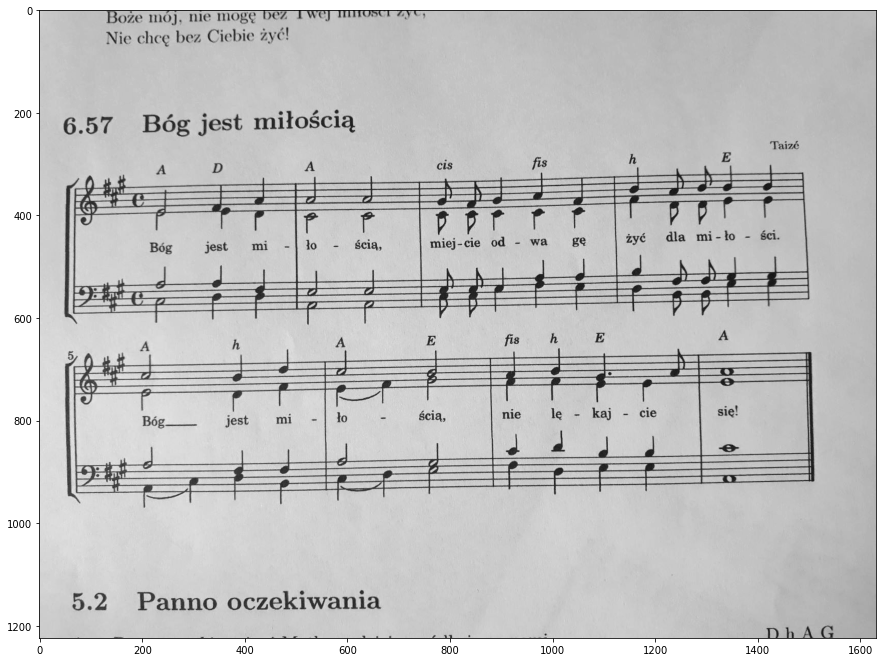

In [2]:
# load a photo of printed sheet music taken with a mobile phone

im = cv2.imread('sample.jpg', 0)
height, width = im.shape
imshow(im)

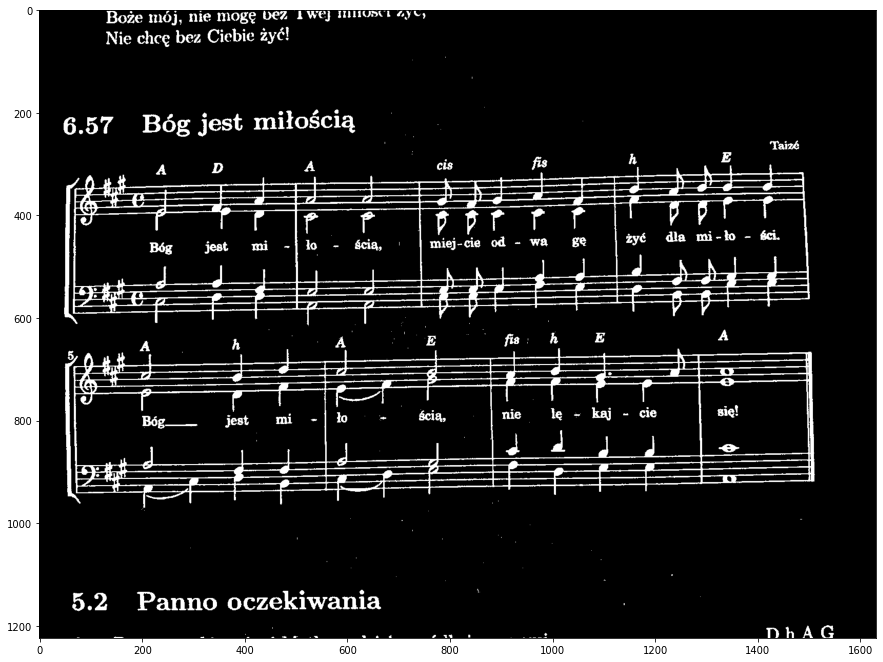

In [3]:
# binarize the image

im_bin = 255 - cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 127, 10)
imshow(im_bin)

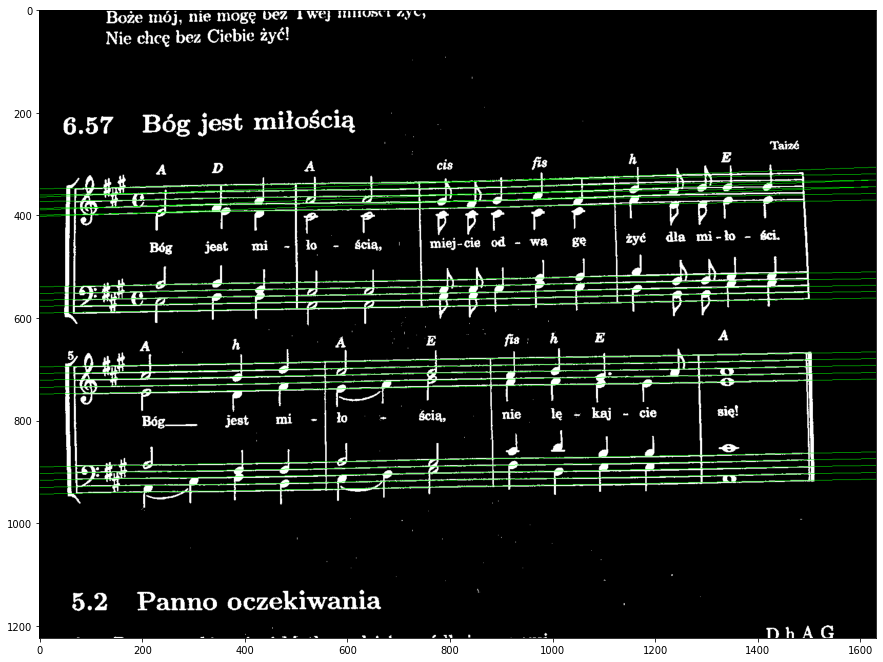

In [4]:
# detect staff lines using the Hough transform

im2 = cv2.cvtColor(im_bin, cv2.COLOR_GRAY2BGR)

lines = cv2.HoughLines(im_bin, 1, np.pi/180, 750)[:, 0, :]
horizontal_lines = np.abs(np.degrees(lines[:, 1] - np.pi/2)) < 15
lines = lines[horizontal_lines]

for line in lines:
    rho, theta = line
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + width*(-b))
    y1 = int(y0 + width*(a))
    x2 = int(x0 - width*(-b))
    y2 = int(y0 - width*(a))

    cv2.line(im2, (x1,y1), (x2,y2), (0,255,0), 1)
imshow(im2)

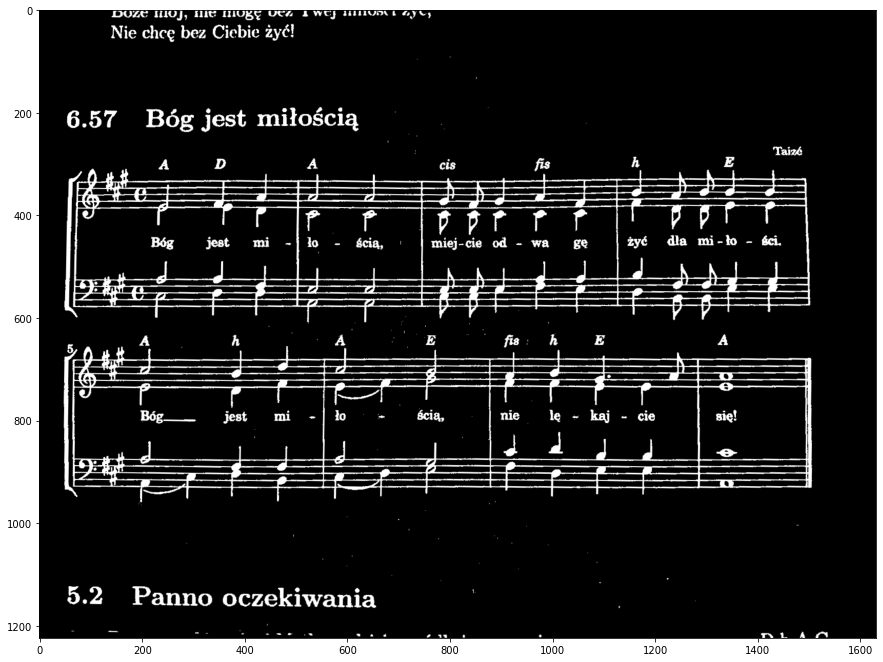

In [5]:
# use detected lines to determine a rotation angle and straighten the image

angles =  np.degrees(lines[:, 1] - np.pi/2)
angles = angles[np.abs(angles) < 15]
angle = np.median(angles)

def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

im_rot = rotate_image(im_bin, angle)
imshow(im_rot)



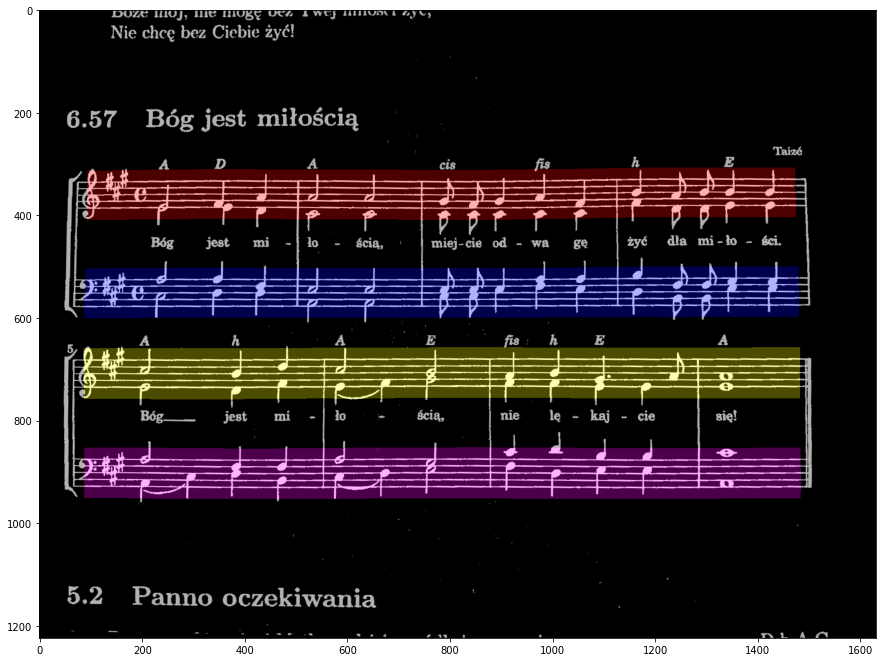

In [6]:
# find bounding boxes of individual staffs

from skimage.measure import label, regionprops
from skimage.color import label2rgb

im2 = cv2.cvtColor(im_rot, cv2.COLOR_GRAY2BGR)

morph_size = 45

im_staves = im_rot
kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (1, morph_size))
im_staves = cv2.dilate(im_staves, kernel1, iterations=1)
kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (morph_size, 1))
im_staves = cv2.erode(im_staves, kernel2, iterations=1)

kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (morph_size, morph_size))
im_staves = cv2.morphologyEx(im_staves, cv2.MORPH_OPEN, kernel3) > 127

staff_regions = label(im_staves)
label_overlay = label2rgb(staff_regions, image=im_rot, bg_label=0)

imshow(label_overlay)

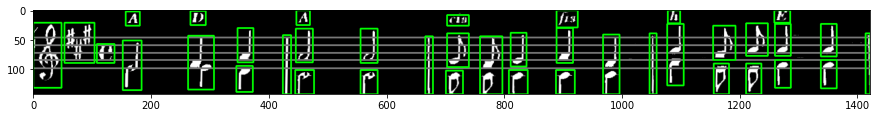

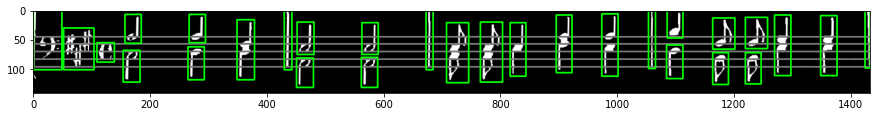

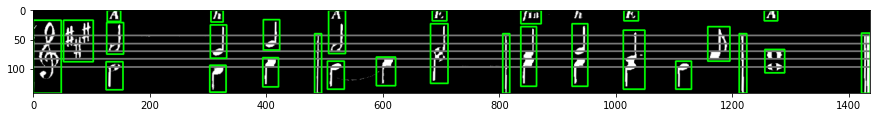

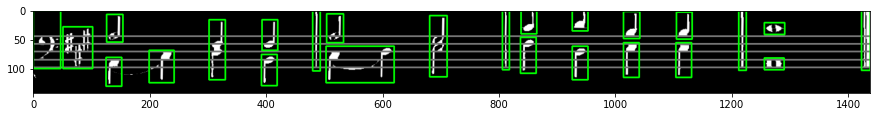

In [7]:
# separate staff lines and detect symbols

from collections import namedtuple

def find_line_coords(only_lines):
    rows = only_lines.mean(axis=1)
    rows = rows * (rows > np.quantile(rows, 0.9))
    # imshow(rows.reshape(-1, 1))
    # plt.bar(np.arange(len(rows)), rows)
    ys = np.where(rows)[0]
    lines = [[]]
    for i, y in enumerate(ys):
        if i >=1 and y - ys[i - 1] > 1:
            lines.append([])
        lines[-1].append(y)
    return np.array([int(np.mean(line_ys)) for line_ys in lines])

margin = 20

Staff = namedtuple('Staff', ['img', 'line_coords', 'symbols'])
staves = []

for region in regionprops(staff_regions):
    y0, x0, y1, x1 = region.bbox
    staff = im_rot[y0-margin:y1+margin, x0-margin:x1+margin]

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,5))
    staff_nolines = cv2.erode(staff, kernel, iterations=1)
    line_coords = find_line_coords(staff - staff_nolines)
    interline = (line_coords[1:] - line_coords[:-1]).mean()

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
    staff_nolines_dilated = cv2.dilate(staff_nolines, kernel, iterations=1) > 127

    symbols = label(staff_nolines_dilated)
    min_area = 2 * interline ** 2
    bboxes = sorted(
        [symbol.bbox for symbol in regionprops(symbols) if symbol.area > min_area],
        key=lambda bbox: bbox[1]
    )

    staves.append(Staff(staff_nolines, line_coords, bboxes))

for staff in staves:
    im2 = cv2.cvtColor(staff.img, cv2.COLOR_GRAY2BGR)
    for y in staff.line_coords:
        cv2.line(im2, (0, y), (im2.shape[1], y), (120, 120, 120), 2)
    for bbox in staff.symbols:
        y0, x0, y1, x1 = bbox
        cv2.rectangle(im2, (x0, y0), (x1, y1), (0, 255, 0), 2)
    imshow(im2)

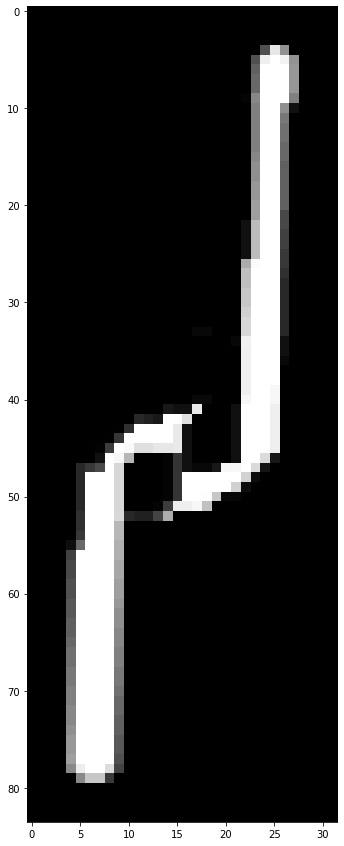

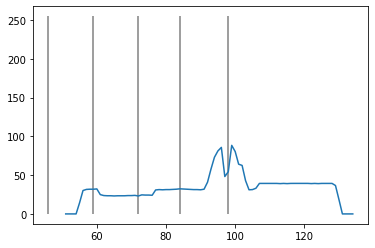

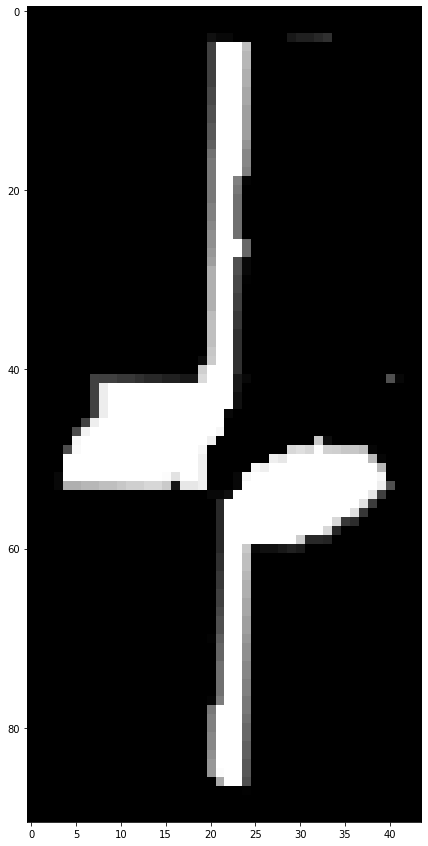

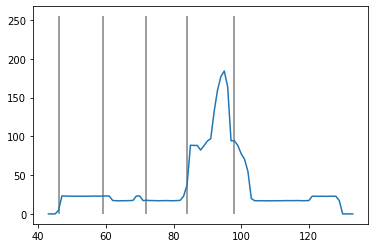

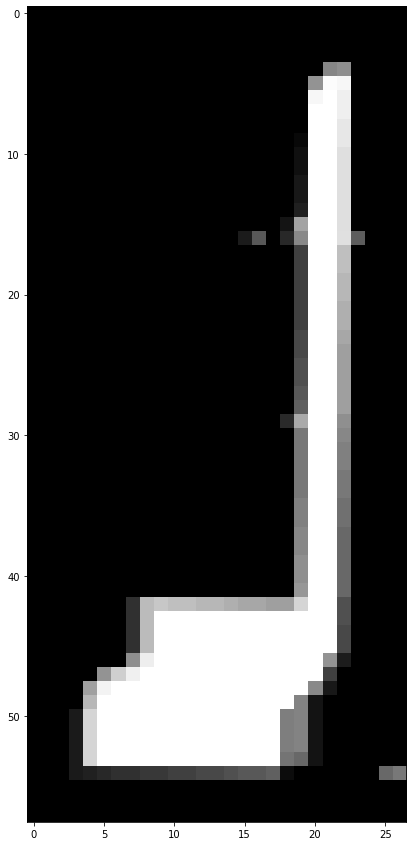

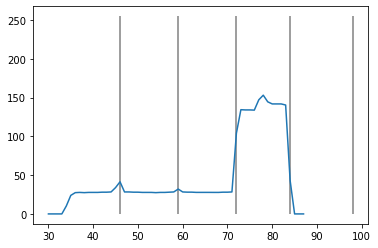

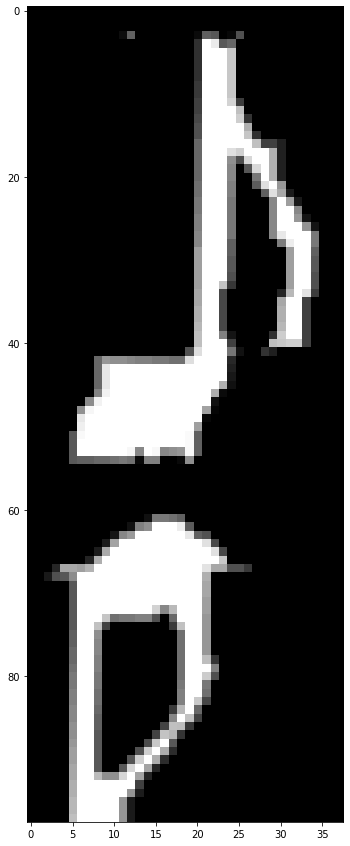

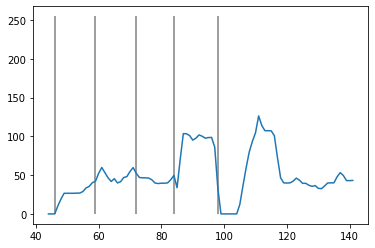

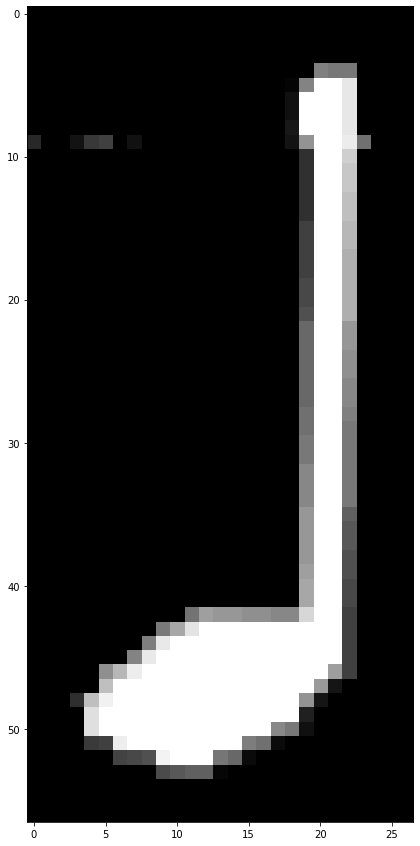

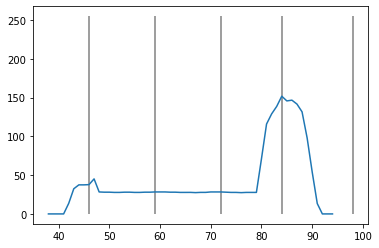

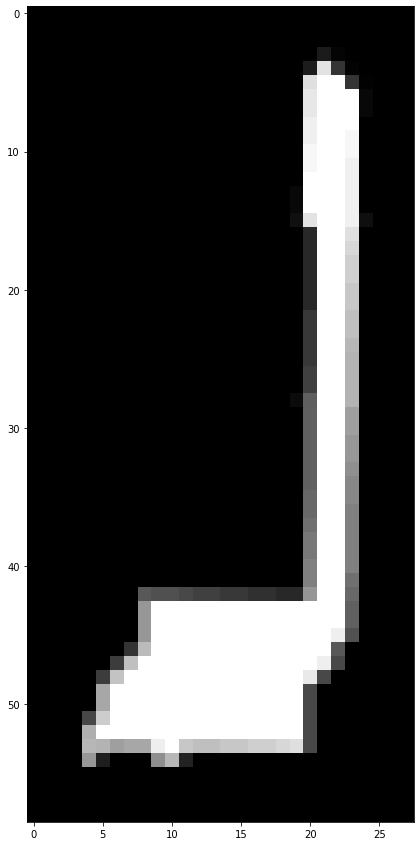

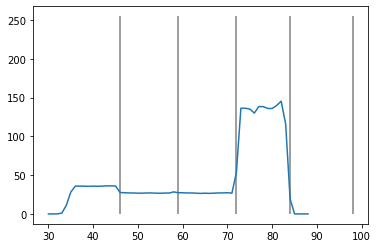

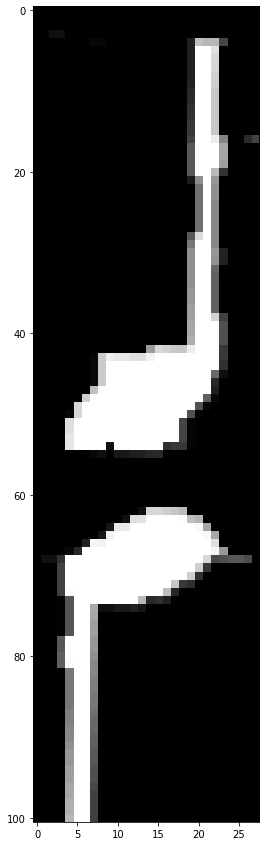

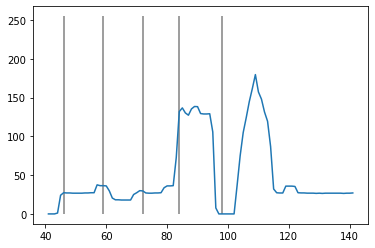

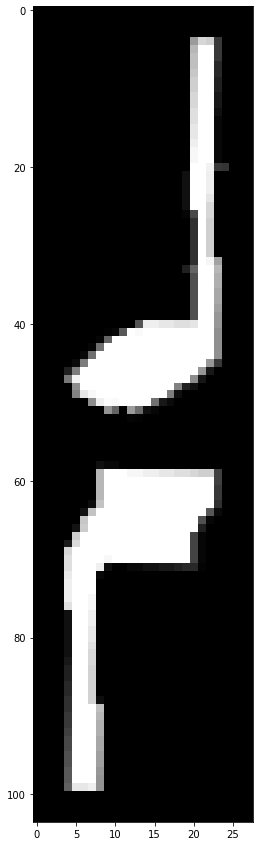

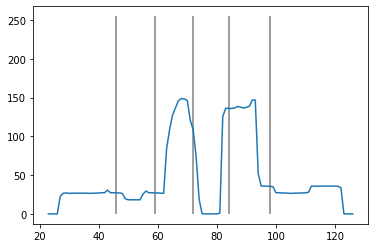

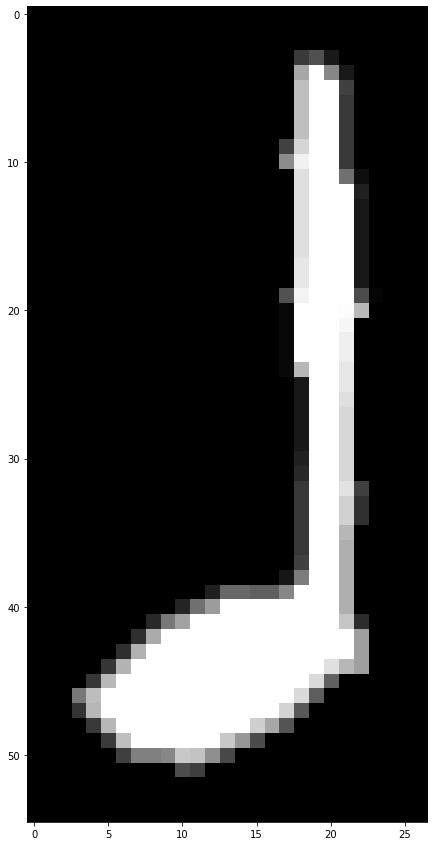

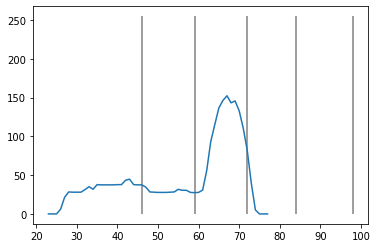

In [8]:
def bbox_to_slice(bbox):
    y0, x0, y1, x1 = bbox
    return slice(y0, y1), slice(x0, x1)

staff = staves[0]
for bbox in staff.symbols:
    y0, x0, y1, x1 = bbox
    is_note = x0 > 10 and 2 < (y1 - y0) / (x1 - x0) < 7 # simple heuristic
    if not is_note:
        continue
    symbol = staff.img[bbox_to_slice(bbox)]
    rows = symbol.mean(axis=1)
    imshow(symbol)
    plt.vlines(staff.line_coords, 0, 255, colors='0.5')
    plt.plot(np.arange(y0, y1), rows)
    plt.show()
    print()

In [9]:
from keras.models import load_model
model = load_model('models/classifier')
classes = ['bass',
 'crotchets',
 'demisemiquaver_line',
 'flat',
 'minim',
 'natural',
 'quaver_br',
 'quaver_line',
 'quaver_tr',
 'semibreve',
 'semiquaver_br',
 'semiquaver_line',
 'semiquaver_tr',
 'sharp',
 'treble']

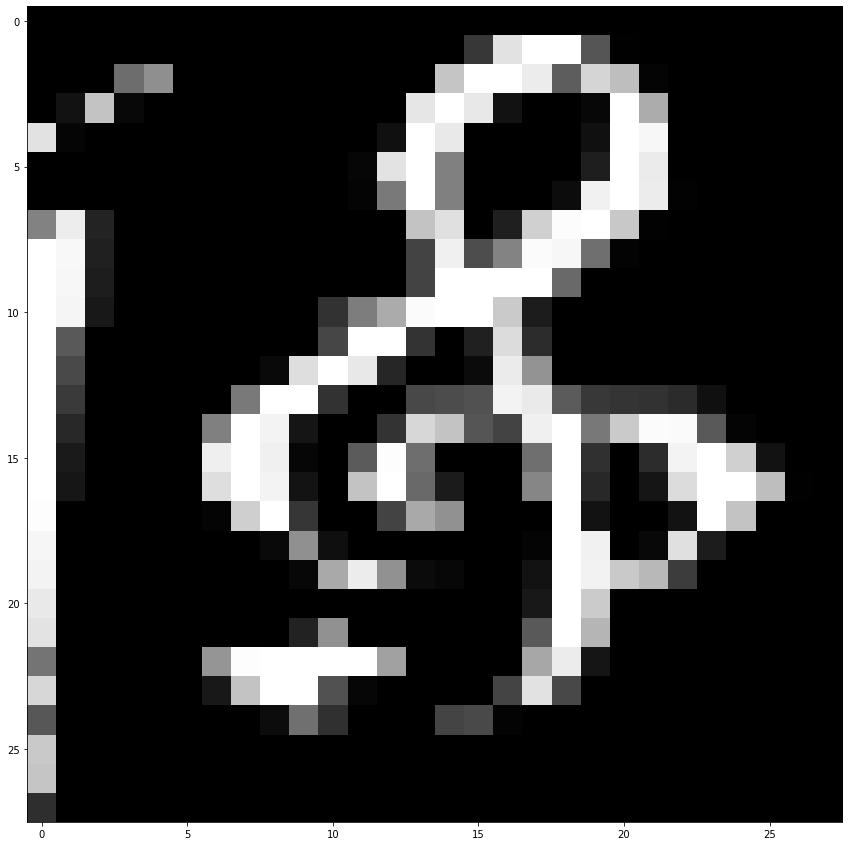

'treble'

In [10]:
staff = staves[0]
test = staff.img[bbox_to_slice(staff.symbols[0])]
test = test / 255.0
test = cv2.resize(test, model.input_shape[1:-1])
imshow(test)
x = test.reshape(1, *model.input_shape[1:])

classes[model.predict(x).argmax()]
